# Cooking receipts (I)

A year ago, this dataset of receipts was post on [Kaggle]( https://www.kaggle.com/c/whats-cooking) . The challenge was to generate a model to predict the cuisine type for a receipt. The dataset, was provide by [yummly](http://www.yummly.com/). Before to see how well different approach perform to predict the cuisine, I had the idea to apply distributed word vectors ([word2vec]( https://en.wikipedia.org/wiki/Word2vec)) to this dataset. 

Word2vec, in a very high level, is an algorithm capable to learn the relationship between words using the context (neighbouring words) they appear in sentences. After training the model, it produces a vector for each word with encodes characteristics of it. Using these vectors, we can cluster the words in or library, or even do operations. The classic example of the latter is; "king - man + woman = queen."

Word2vec uses recurrent neural networks to learn, then usually works better with huge datasets (billions of words), but we will see how it performs with the cooking dataset, where each receipt will be a sentence. One of the best features of this algorithm published by Google is the speed. Other recurrent neural networks had been proposed, however they were insanely CPU time consuming. If you want more detailed information about this, I strongly suggest you to read about [here]( https://www.google.ca/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwiU5PmPoOPSAhVn5IMKHcIUDmIQFggaMAA&url=https%3A%2F%2Fpapers.nips.cc%2Fpaper%2F5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf&usg=AFQjCNFvn2t3S41dxIocYbx5EpeOwmjXVQ&sig2=IxYxjFBtWI_BkYLKymPAsw&bvm=bv.149760088,d.amc), [here]( https://www.quora.com/How-does-word2vec-work) and [here]( https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/) : . Now let’s tackle our dataset. 


## General Exploration of the Dataset

Although this dataset is probably quite clean, do a general exploration of our data is really good habit, no matter what kind of model you will apply to them. Plot a few frequencies and means can provide a value information of all sorts about potential problems, bias, typos, etc.




In [130]:
from __future__ import print_function

# Handle data
import json
import operator
import collections
import re

# Handle table-like data 
import numpy as np
import pandas as pd

# Model Algorithms
# we could use also tensor flow, there are multiple implementations of word2vec
from gensim.models import word2vec

# Modelling Helpers, see above the description
from sklearn.manifold import TSNE

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

In [131]:
# Load the dataset
# json format labels: cuisine, id number and ingredients (list)
trainrecipts = json.load(open('train.cooking.csv','r'))

In [132]:
# Quick&dirty code to extract info2list
raw_ingredients = list()

for recipt in trainrecipts:
    for ingredient in recipt[u'ingredients']:
        raw_ingredients.append(ingredient.strip())
        

raw_cuisines = list()
for recipt in trainrecipts:
    raw_cuisines.append(recipt[u'cuisine'].strip())






In [133]:

# use Counter to get frequencies 
counts_ingr = collections.Counter(raw_ingredients)
counts_cuis = collections.Counter(raw_cuisines)

## Exploring the Dataset.
### Cuisines

In [134]:
# this will help us to have an idea how our corpora of 
# ingredients looks like
print('Size Ingredients dataset (with repetition):  \t{}'.format((len(raw_ingredients))))
print('Unique Ingredients dataset: \t\t\t{}'.format((len(counts_ingr.values()))))

# This will provide a distribution of cusines, indirect 
# info of the ingredients
print('Total # of recipts \t\t\t\t{}'.format(len(raw_cuisines)))
print('Total # of Cuisines \t\t\t\t{}'.format((len(counts_cuis.values()))))


Size Ingredients dataset (with repetition):  	428275
Unique Ingredients dataset: 			6714
Total # of recipts 				39774
Total # of Cuisines 				20


In [135]:
# top 10
counts_cuis.most_common(10)

[(u'italian', 7838),
 (u'mexican', 6438),
 (u'southern_us', 4320),
 (u'indian', 3003),
 (u'chinese', 2673),
 (u'french', 2646),
 (u'cajun_creole', 1546),
 (u'thai', 1539),
 (u'japanese', 1423),
 (u'greek', 1175)]

In [136]:
# Distribution 

print(np.mean(counts_cuis.values()))
print(np.std(counts_cuis.values()))

1988.7
1989.86534972


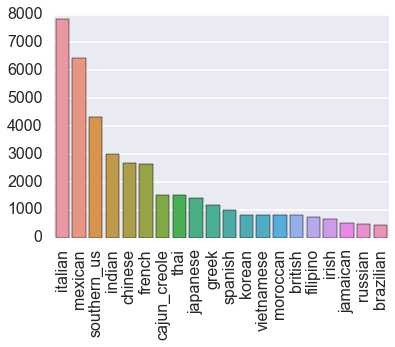

In [137]:
# lets plot this 
# sort
x_cu = [cu for cu, frq in counts_cuis.most_common()]
y_frq = [frq for cu, frq in counts_cuis.most_common()]
fbar = sns.barplot(x = x_cu, y = y_frq)
# xlabels
for item in fbar.get_xticklabels():
    item.set_rotation(90)

For instance, as we can see in the first plot, Italian and Mexican receipts represent more than a third of the entire dataset. So, it is probable that this will affect how our vectors form. It is good to keep this on mind for this or any other further model we apply to this dataset. Let’s check if there is a bias on the size of the receipts. 
 


### Ingredients

Other interesting parameter is the size of the receipts, how long are they? there is any bias?

In [138]:
# init a dict with a empty list
num_ingredients = dict(zip(counts_cuis.keys(), [list() for x in counts_cuis.keys()]))
for recipt in trainrecipts:
    # append the number in the list
    num_ingredients[recipt['cuisine']].append(len(recipt['ingredients']))

len(num_ingredients)

20

In [139]:
for cu, frq in num_ingredients.items():

    print('{}    \t\t{:.2f}'.format(cu, np.mean(frq)))

irish    		9.30
mexican    		10.88
chinese    		11.98
filipino    		10.00
vietnamese    		12.68
spanish    		10.42
japanese    		9.74
moroccan    		12.91
french    		9.82
greek    		10.18
indian    		12.71
jamaican    		12.21
british    		9.71
brazilian    		9.52
russian    		10.22
cajun_creole    		12.62
thai    		12.55
southern_us    		9.63
korean    		11.28
italian    		9.91


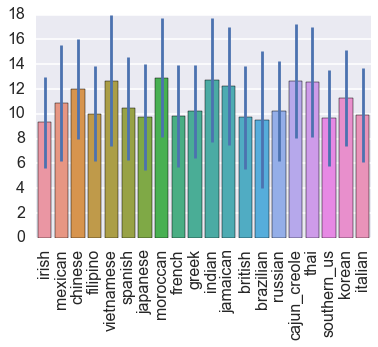

In [140]:
x_cu = [cu for cu, frq in num_ingredients.items()]
y_frq = [np.mean(frq) for cu, frq in num_ingredients.items()]
err = [np.std(frq) for cu, frq in num_ingredients.items()]
fbar = sns.barplot(x = x_cu, y = y_frq, yerr=err)
# xlabels
for item in fbar.get_xticklabels():
    item.set_rotation(90)

Well, on terms of size, all the receipts appear to be more similar. Then, let’s focus on the ingredients. As I mentioned above, I guess this dataset is really clean, or at least more than a real-world dataset and I do not expect any pre-processing. Also, full disclaimer, I did not check any of the models submitted to kaggel, and my intention is build the word2vec with as a proof of concept.



In [141]:
# Dispersion of the frequencies Ingredients
print(np.mean(counts_ingr.values()))
print(np.std(counts_ingr.values()))



63.7883526959
388.327025966


The frequency of the ingredients presents a similar scenario, a few ingredients are tremendously popular. Make sense, some ingredients as salt, or water are common in any recipes.  Half of the ingredients only appear 4 or less times in the dataset, that is wide less what I expected. Let's check the most popular.


In [142]:
# This is to big to plot, let's check the percentiles
print(np.median(counts_ingr.values()))
print(np.percentile(counts_ingr.values(), [25., 50., 75., 99.]))



4.0
[  1.00000000e+00   4.00000000e+00   2.00000000e+01   1.15644000e+03]


In [143]:
1.15644000e+03

1156.44

Half of the ingredients only appear 4 or less times in the dataset, that is wide less what I expected. Let's check the most populars.

In [144]:
# top 15
counts_ingr.most_common(15)

[(u'salt', 18049),
 (u'olive oil', 7972),
 (u'onions', 7972),
 (u'water', 7457),
 (u'garlic', 7380),
 (u'sugar', 6434),
 (u'garlic cloves', 6237),
 (u'butter', 4848),
 (u'ground black pepper', 4785),
 (u'all-purpose flour', 4632),
 (u'pepper', 4438),
 (u'vegetable oil', 4385),
 (u'eggs', 3388),
 (u'soy sauce', 3296),
 (u'kosher salt', 3113)]

A few ingredients like Salt and water make a lot of sense that they are highly frequent, but the present of olive oil among these omnipresent ingredients make me think that is an artefact of the bias of the dataset to the Italian cooking.  


In [145]:
counts_ingr.most_common()[-50:]

[(u'whole wheat seasoned breadcrumbs', 1),
 (u'Foster Farms boneless skinless chicken breasts', 1),
 (u'Doritos Tortilla Chips', 1),
 (u'smoked turkey drumstick', 1),
 (u'Wholesome Sweeteners Organic Sugar', 1),
 (u'stem ginger', 1),
 (u'farfalline', 1),
 (u'lipton green tea bag', 1),
 (u'plain soy yogurt', 1),
 (u'meat-filled tortellini', 1),
 (u'cold-smoked salmon', 1),
 (u'ranch-style seasoning', 1),
 (u'lotus leaves', 1),
 (u'white quinoa', 1),
 (u'high gluten bread flour', 1),
 (u'blueberry pie filling', 1),
 (u'Pillsbury Thin Pizza Crust', 1),
 (u'Greek black olives', 1),
 (u'crouton italian season', 1),
 (u'raspberry fruit spread', 1),
 (u'creme de cacao', 1),
 (u'Crisco Pure Canola Oil', 1),
 (u'wheat crackers', 1),
 (u'muscadet', 1),
 (u'mini pepperoni slices', 1),
 (u'spinach tortilla', 1),
 (u'vanilla low-fat frozen yogurt', 1),
 (u'dried shallots', 1),
 (u'pike', 1),
 (u'morcilla', 1),
 (u'shark steak', 1),
 (u'creole seasoning mix', 1),
 (u'chinese baby corn', 1),
 (u'sats

There are some very specific ingredients... I expect that some of those are typos, or just versions of other ingredients.


Also notice that in the dataset the same ingredient can present in different formats, garlic, and garlic cloves. First a quick search for parenthesis or similar symbols that rise a red flag to typos, or weird writing 


In [146]:
symbols = list()

for recipt in trainrecipts:

    # I want ingredient remove 
    for ingredient in recipt['ingredients']:
        if re.match("\(|@|\$\?", ingredient.lower()):
            symbols.append(ingredient)
len(symbols)
counts_symbols = collections.Counter(symbols)

In [147]:
counts_symbols.most_common(20)

[(u'(    oz.) tomato sauce', 11),
 (u'(   oz.) tomato paste', 9),
 (u'(10 oz.) frozen chopped spinach', 3),
 (u'(15 oz.) refried beans', 3),
 (u'(14.5 oz.) diced tomatoes', 3),
 (u'(14 oz.) sweetened condensed milk', 2),
 (u'(10 oz.) frozen chopped spinach, thawed and squeezed dry', 2)]

In [148]:
measurements = list()

for recipt in trainrecipts:

    # I want ingredient remove 
    for ingredient in recipt['ingredients']:
        if re.match(r"tbsp", ingredient.lower()):
            measurements.append(ingredient)
len(measurements)
counts_ms = collections.Counter(measurements)

In [149]:
counts_ms

Counter()

In [150]:
garlic = list()

for recipt in trainrecipts:

    # I want ingredient remove 
    for ingredient in recipt['ingredients']:
        if re.match("garlic", ingredient.lower()):
            garlic.append(ingredient)
len(garlic)
counts_garlic = collections.Counter(garlic)

In [151]:
counts_garlic.most_common(15)

[(u'garlic', 7380),
 (u'garlic cloves', 6237),
 (u'garlic powder', 1442),
 (u'garlic paste', 282),
 (u'garlic salt', 240),
 (u'garlic chili sauce', 130),
 (u'garlic chives', 25),
 (u'garlic puree', 16),
 (u'garlic bulb', 14),
 (u'garlic sauce', 11),
 (u'garlic oil', 9),
 (u'garlic pepper seasoning', 8),
 (u'garlic herb feta', 4),
 (u'garlic shoots', 4),
 (u'garlic and herb seasoning', 3)]

In [152]:
salt = list()

for recipt in trainrecipts:

    # I want ingredient remove 
    for ingredient in recipt['ingredients']:
        if re.match("salt", ingredient.lower()):
            salt.append(ingredient)
len(salt)
counts_salt = collections.Counter(salt)

In [153]:
counts_salt.most_common(10)

[(u'salt', 18049),
 (u'salt and ground black pepper', 215),
 (u'salted butter', 77),
 (u'saltines', 38),
 (u'salted peanuts', 38),
 (u'salt pork', 37),
 (u'salted roast peanuts', 33),
 (u'salted cashews', 8),
 (u'salted dry roasted peanuts', 8),
 (u'salted fish', 5)]

Well, I guess some pre-processing could be good, but let's see how our model behave. Let's train the neural network with a raw version of the dataset.


In [154]:
sentences = list()
# one hot ingredients


for recipt in trainrecipts:
    clean_recipt = list()
    # I want ingredient remove 
    for ingredient in recipt['ingredients']:
        # remove this description from the ingredients
        # minimal preprocessing
        ingredient =  re.sub(r'\(.*oz.\)|crushed|crumbles|ground|minced|powder|chopped|sliced',
                             '', 
                             ingredient)
        clean_recipt.append(ingredient.strip())
    sentences.append(clean_recipt)
        
len(sentences)

39774

In [155]:
# Set values for NN parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 3    # 50% of the corpus                    
num_workers = 4       # Number of CPUs
context = 10          # Context window size; 
                      # let's use avg recipte size                                                                                  
downsampling = 1e-3   # threshold for configuring which 
                    # higher-frequency words are randomly downsampled

# Initialize and train the model 
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

Once the model is train we can ask him a few questions, for example what is similar to feta cheese. Looks like all the ingredients are stuff that you expect to find with feta cheese, and looks like they belong to Greek cuisine.


In [156]:
model.most_similar(u'feta cheese')

[(u'kalamata', 0.9356829524040222),
 (u'pitas', 0.8994108438491821),
 (u'pitted kalamata olives', 0.8983321785926819),
 (u'olives', 0.8962057828903198),
 (u'fresh oregano', 0.885500431060791),
 (u'tzatziki', 0.8802902698516846),
 (u'roasted red peppers', 0.8741425275802612),
 (u'pita bread rounds', 0.8648422956466675),
 (u'grape tomatoes', 0.8638047575950623),
 (u'greek seasoning', 0.8619629144668579)]

In [157]:
#let try something more tricky, like salt

In [158]:
model.most_similar(u'salt')

[(u'sea salt', 0.6929489970207214),
 (u'kosher salt', 0.6056641340255737),
 (u'coarse salt', 0.516398012638092),
 (u'chicken schmaltz', 0.4543069005012512),
 (u'dried chile peppers', 0.4323074519634247),
 (u'habanero hot sauce', 0.4129718542098999),
 (u'kidney', 0.41258928179740906),
 (u'non dairy milk', 0.4067976772785187),
 (u'dried split peas', 0.404290109872818),
 (u'skinless chicken thighs', 0.39152979850769043)]

In [159]:
model.most_similar(u'chicken broth')

[(u'smoked sausage', 0.9381110668182373),
 (u'andouille sausage', 0.9107339382171631),
 (u'green pepper', 0.9098533391952515),
 (u'okra', 0.901829719543457),
 (u'Tabasco Pepper Sauce', 0.8931988477706909),
 (u'black-eyed peas', 0.888864278793335),
 (u'celery', 0.8872207403182983),
 (u'red beans', 0.8847018480300903),
 (u'bell pepper', 0.8786205053329468),
 (u'creole seasoning', 0.8625714778900146)]

In [160]:
model.similarity('rice','beans')

0.84303316031195263

In [161]:
model.similarity('rice','pasta')

0.077343113610447517

In [162]:
model.similarity('broccoli', 'bacon')


0.35054050495038624

In [163]:
model.similarity('broccoli', 'carrots')


0.62243354080235946

In [164]:
model.similarity('broccoli', u'mushrooms')

0.83966134105435541

In [165]:
#['garlic', 'onion'], ['olive oil']
x = 'basil'
b= 'tomato sauce'
a = 'pasta'
predicted = model.most_similar([x, b], [a])[0][0]
print(" {} is to  {} as {} is to {} ".format(a, b, x, predicted))

 pasta is to  tomato sauce as basil is to lean  meat 


In [166]:
#['garlic', 'onion'], ['olive oil']
x = 'chicken'
b= 'broccoli'
a = 'bacon'
predicted = model.most_similar([x, b], [a])[0][0]
print(" {} is to  {} as {} is to {} ".format(a, b, x, predicted))

 bacon is to  broccoli as chicken is to chili paste 


In [167]:
#['garlic', 'onion'], ['olive oil']
x = 'chicken'
b= 'cacao'
a = 'bacon'
predicted = model.most_similar([x, b], [a])[0][0]
print(" {} is to  {} as {} is to {} ".format(a, b, x, predicted))

 bacon is to  cacao as chicken is to tamarind paste 


In [168]:
model.wv.most_similar_cosmul(positive=['pasta', u'meat'], negative=['tomato sauce'])

[(u'hard-boiled egg', 1.0102736949920654),
 (u'watercress', 1.0091077089309692),
 (u'tuna', 1.0027183294296265),
 (u'chives', 1.0014901161193848),
 (u'anchovies', 1.0000135898590088),
 (u'white mushrooms', 0.9992201924324036),
 (u'squid', 0.9923979043960571),
 (u'boneless rib eye steaks', 0.9902346134185791),
 (u'bay scallops', 0.9850444197654724),
 (u'oyster mushrooms', 0.9834839701652527)]

In [169]:
model.wv.most_similar_cosmul(positive=['chili', u'meat'], negative=['tomato sauce'])

[(u'peanut', 1.293039083480835),
 (u'tamarind paste', 1.2694698572158813),
 (u'cilantro leaves', 1.256188154220581),
 (u'tamarind', 1.2492636442184448),
 (u'coconut oil', 1.244247317314148),
 (u'tamarind concentrate', 1.2239196300506592),
 (u'lime', 1.2217503786087036),
 (u'hot chili', 1.2203289270401),
 (u'rice flour', 1.2200920581817627),
 (u'coconut cream', 1.2179442644119263)]

In [170]:
model.most_similar(u'garlic')

[(u'red pepper flakes', 0.7015829086303711),
 (u'chicken breasts', 0.6516435742378235),
 (u'bell pepper', 0.6331510543823242),
 (u'garlic cloves', 0.6044415235519409),
 (u'boneless skinless chicken breasts', 0.5945265293121338),
 (u'shrimp tails', 0.5900548696517944),
 (u'green pepper', 0.5900425314903259),
 (u'white rice', 0.5897176265716553),
 (u'chicken broth', 0.5832070112228394),
 (u'yellow onion', 0.5763946771621704)]

In [171]:
corpus = sorted(model.wv.vocab.keys()) #not sure the exact api
emb_tuple = tuple([model[v] for v in corpus])
X = np.vstack(emb_tuple)

In [172]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

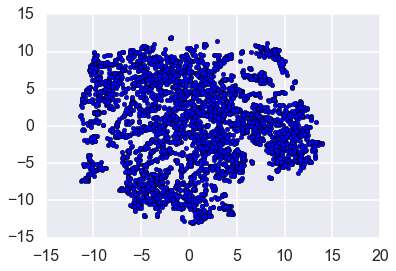

In [173]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])



Looks like there are some clusters of ingredients but is difficult to say anything else without adding labels or colors. Let's start easy and color each ingredient by the cuisine where it is more frequent. I will normalize the frequency.


In [174]:
#
# I will label a ingredient by frequency 
track_ingredients = dict(zip(counts_cuis.keys(), [list() for x in counts_cuis.keys()]))
for recipt in trainrecipts:
    # append the number in the list
    clean_recipt = list()
    # I want ingredient remove 
    for ingredient in recipt['ingredients']:
        # remove this description from the ingredients
        # (10 oz.) 
        ingredient =  re.sub(r'crushed|crumbles|ground|minced|powder|chopped|sliced', '', ingredient)
        clean_recipt.append(ingredient.strip())
        
    track_ingredients[recipt['cuisine']].extend(clean_recipt)

for label, tracking in track_ingredients.items():
    track_ingredients[label] = collections.Counter(tracking)

In [175]:
def return_most_popular(v):
    cuisine = None
    record = 0
    for label, tracking in track_ingredients.items():
        norm_freq = float(tracking[v]) / float(counts_cuis[label])
        if norm_freq > record:
            cuisine = label
            record = norm_freq
    return cuisine

In [176]:
track_2color = {u'irish':"#000000", # blak
                u'mexican':"#FFFF00", #yellow
                u'chinese':"#1CE6FF", #cyan
                u'filipino': "#FF34FF", #pink 
                u'vietnamese':"#FF4A46", #red
                u'spanish':"#FFC300",  # green forest
                u'japanese':"#006FA6", # blue ocean
                u'moroccan':"#A30059",# purple
                u'french':"#FFDBE5",  #light pink
                u'greek': "#7A4900",  # gold or brown 
                u'indian':"#0000A6", # blue electric 
                u'jamaican':"#63FFAC", # green phospho
                u'british': "#B79762", #brown
                u'brazilian': "#EEC3FF", #  
                u'russian':"#8FB0FF", # light blue 
                u'cajun_creole':"#997D87", #violet
                u'thai':"#5A0007", 
                u'southern_us':"#809693", 
                u'korean':"#FEFFE6", #ligt yellow
                u'italian':"#1B4400"}

color_vector = list()
for v in corpus:
    cuisine = return_most_popular(v)
    color_vector.append(track_2color[cuisine])

In [177]:
# ensemble the legend
lgend = list()
for l, c in track_2color.items():
    lgend.append(mpatches.Patch(color=c, label=l))

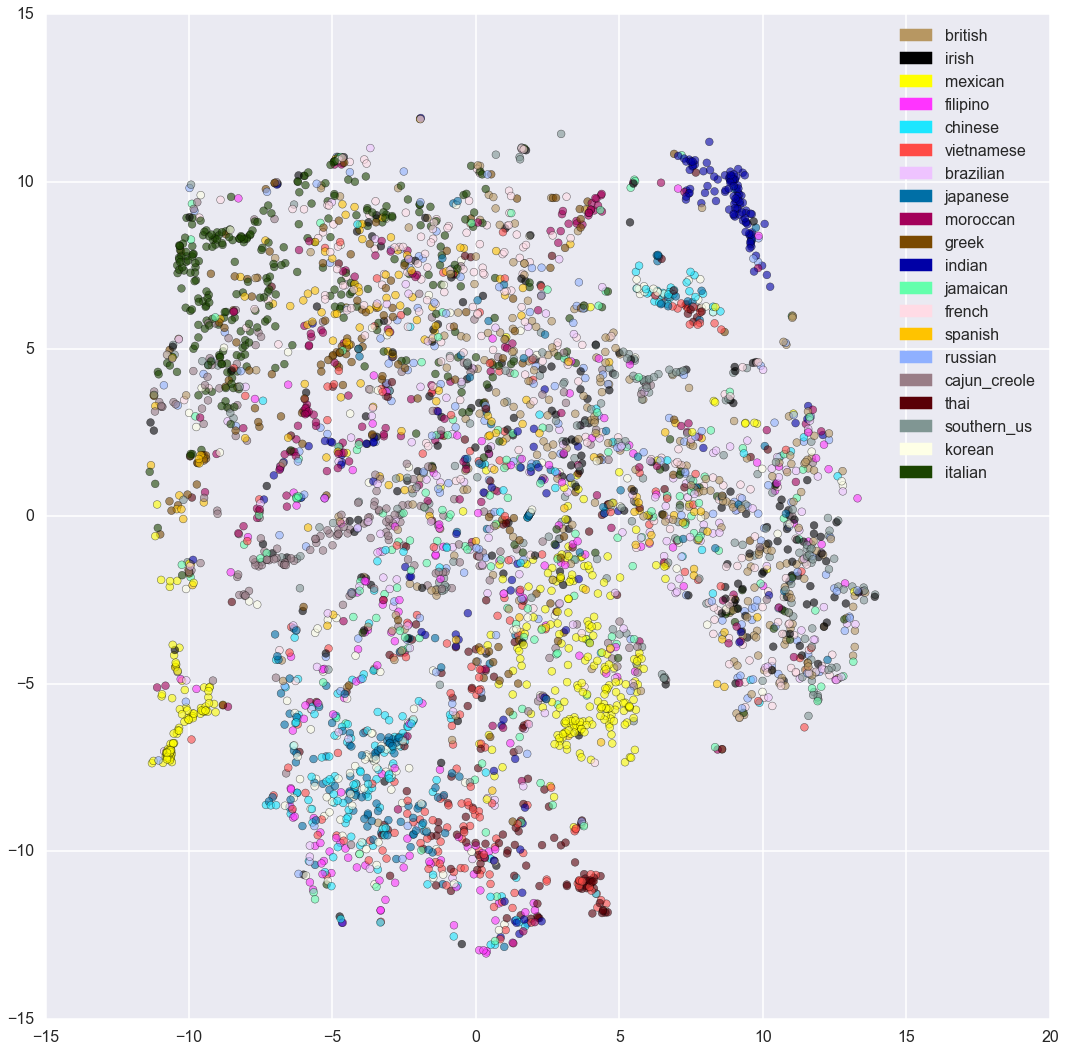

In [178]:
sns.set_context("poster")
fig, ax = plt.subplots(figsize=(18,18))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color_vector, alpha=.6, s=60)
plt.legend(handles=lgend)